In [138]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt

In [139]:
# Get a list of image paths
masks = glob.glob("./ISIC2018_Task1_Training_GroundTruth_x2/*.png")
images = glob.glob("./ISIC2018_Task1_2_Training_Input_x2/*.jpg")

In [340]:
# Sort the images, as glob doesn't gaurentee same ordering as files
masks.sort()
images.sort()
# Convert the list of strings into a 1d  string tensor
masksTf = tf.data.Dataset.from_tensor_slices(masks)
imagesTf = tf.data.Dataset.from_tensor_slices(images)

['./ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000000.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000001.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000003.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000004.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000006.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000007.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000008.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000009.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000011.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000012.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000013.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000014.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000015.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000016.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000017.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000018.jpg', './ISIC2018_Task1_2_Training_Input_x2\\ISIC_0000019.jpg', './ISIC2018_T

In [141]:
def load_jpeg(image):
    # Load the image turn into jpeg
    decoded = tf.io.read_file(image)
    imageTf = tf.image.decode_jpeg(decoded)
    # Normalize the images
    returnImage = tf.cast(imageTf, tf.float32) / 255.0
    return returnImage

def load_png(image):
    # Load the image turn into png
    decoded = tf.io.read_file(image)
    imageTf = tf.image.decode_png(decoded)
    return imageTf

In [142]:
masksTfImages = masksTf.map(load_png)
imagesTfImages = imagesTf.map(load_jpeg)

In [143]:
# Plots a given image and mask
def display(image, mask):
    plt.figure(figsize=(15, 15))
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
    plt.axis("off")
    plt.show()

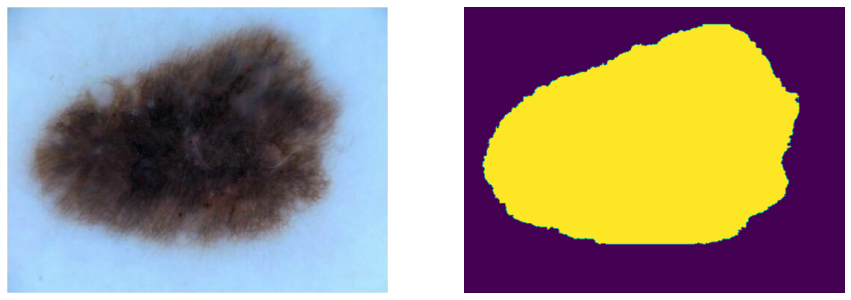

In [144]:
# Plot the images, namely to see if the plots tensor are properly configured
for imageTf in imagesTfImages.take(1):
    image = imageTf
for maskTf in masksTfImages.take(1):
    mask = maskTf

display(image, mask)

In [145]:
#Find the smallest image dimensions, and whether those dimensions are from seperate or the same image. 
minx = miny = 10000
seperate_images = True
for image in imagesTfImages:
    minxUpdated = False
    if image.shape[0] < minx:
        minx = image.shape[0]
        minxUpdated = True
    if image.shape[1] < miny:
        miny = image.shape[1]
        if minxUpdated:
            seperate_images = False
        
print(f"Min x: {minx}. Min y: {miny}. Seperate Images: {seperate_images}")

Min x: 270. Min y: 288. Seperate Images: False


In [146]:
# Reshape every image to have those dimensions. Include padding as position of the lesions may be important in classification
# Note that this may need to be changed later, maybe certain images of a certain aspect ratio have lesions in a certain position?
def resizeImages(image):
    return tf.image.resize_with_pad(image, 270, 288)

imagesResized = imagesTfImages.map(resizeImages)
masksResized = masksTfImages.map(resizeImages)

(270, 288, 3)


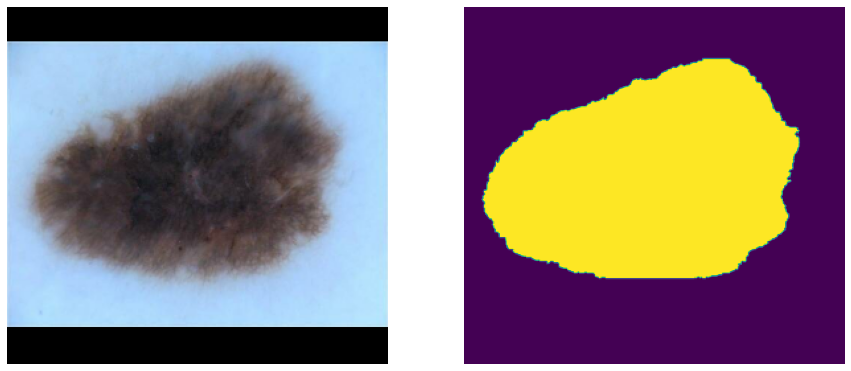

In [339]:
# Plot an image, check to se how they look after resize
for imageTf in imagesResized.take(1):
    imagePlot = imageTf
    print(imageTf.shape)
for maskTf in masksResized.take(1):
    maskPlot = maskTf
    
display(imagePlot, maskPlot)

In [325]:
# Count the number of pixels that aren't 0. This implicity gives starting pixel location of mask.
def nonZeroCount(image):
    rowNonZero = tf.math.count_nonzero(image, axis=0)
    colNonZero = tf.math.count_nonzero(image, axis=1)
    # Flattens the tensors to be a list
    rowNonZeroList = tf.reshape(rowNonZero, [-1])
    colNonZeroList = tf.reshape(colNonZero, [-1])
    return rowNonZeroList, colNonZeroList

# Get index of first non zero given list of values
def firstNonZero(boolList):
    firstTrue = -1
    for pos in boolList:
        firstTrue += 1
        if pos != 0:
            break
    return firstTrue

# Gets pixel positions (relative to image size) of the bounding box
def getPixelPositions(image):
    xDiv = image.shape[1] # 288
    yDiv = image.shape[0] # 270
    rowNon, colNon = nonZeroCount(image)
    xMin = firstNonZero(rowNon)
    xMax = (rowNon.shape[0] - firstNonZero(tf.reverse(rowNon, [-1])))
    yMin = firstNonZero(colNon)
    yMax = (colNon.shape[0] - firstNonZero(tf.reverse(colNon, [-1])))
    return [xMin, xMax, yMin, yMax]

def convertToYoloFormat(pixelPositions, imageClass=0):
    # Format is [imageClass, center_x, center_y, width, height]
    xMin, xMax, yMin, yMax = pixelPositions
    centerX = int(xMax/2)/288
    centerY = int(yMax/2)/270
    width = (xMax - xMin)/288
    height = (yMax - yMin)/270
    return [imageClass, centerX, centerY, width, height]

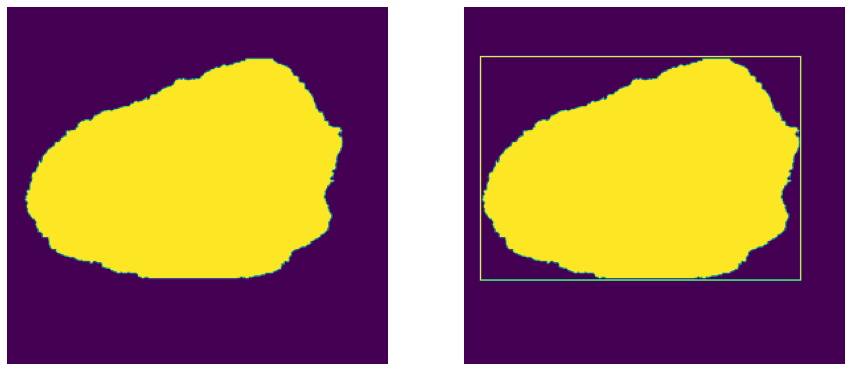

In [326]:
# Check that functions work properly
for image in masksResized.take(1):
    imageTest = image
    xMin, xMax, yMin, yMax = getPixelPositions(image)

#Convert image to float32 (required for draw_bounding_boxes)
image = tf.image.convert_image_dtype(imageTest, dtype=tf.float32)
# Reshape to [batch, height, width, depth]
img = tf.reshape(img, shape=[1, 270, 288, 1])
boundingBox = tf.stack([xMin, xMax, yMin, yMax], axis=0)
# Reshape to [batch, num_bounding_boxes, 4]
boundingBox = tf.reshape(box, shape=[1,1,4])
colors = [[255.0, 0.0, 1.0]]
newImage = tf.image.draw_bounding_boxes(img, boundingBox, colors)
display(imageTest, bounding_box.numpy()[0])

In [347]:
# Find yolo formatted bounding box for every image. 
output = []
for image in masksResized:
    imageTest = image
    pixelPositions = getPixelPositions(image)
    output.append(convertToYoloFormat(pixelPositions))

In [348]:
with open('boundingBoxes.txt', 'w') as f:
    for box in output:
        f.write("%s\n" % ', '.join(map(str,box)))

In [345]:
# Save all images the have been reshaped:
count = 0
for image in imagesResized:
    count += 1
    if count < 10:
        fileName = f"00000{count}"
    elif count < 100:
        fileName = f"0000{count}"
    elif count < 1000:
        fileName = f"000{count}"
    else:
        fileName = f"00{count}"
    tf.keras.preprocessing.image.save_img(f"new_images/{fileName}.jpg", image.numpy())